In [1]:
import seaborn as sns
import datetime as dt

def loggg(with_dataframe = False):    
    def decorator(f):
        
        if with_dataframe == True: 
            def wrapper(dataf, *args, **kwargs):
                tic = dt.datetime.now() #Время начала выполнения функции
                result = f(dataf, *args, **kwargs) #Выполнения функции
                toc = dt.datetime.now() #Время окончания работы функции

                #Если у dataf и result есть аттрибут shape, то добавляются названия колонн и делается заптсь об изменении shape
                if hasattr(dataf, 'shape') and hasattr(result, 'shape'): 
                    share_before = dataf.shape
                    shape_after = result.shape
                    added_columns = set(result.columns) - set(dataf.columns)
                    print(f"{f.__name__},  shape {dataf.shape}->{result.shape},  took={toc-tic}")
                    
                else:
                    print(f"{f.__name__} took={toc-tic}")
                    
                return result
            
        else:
            def wrapper(*args, **kwargs):

                tic = dt.datetime.now() #Время начала выполнения функции
                result = f(*args, **kwargs) #Выполнения функции
                toc = dt.datetime.now() #Время окончания работы функции

                #Если у dataf и result есть аттрибут shape, то добавляются названия колонн и делается заптсь об изменении shape
                if  hasattr(result, 'shape'): 
                    shape_after = result.shape
                    print(f"{f.__name__},  result_shape={result.shape},  took={toc-tic}")
                    
                else:
                    print(f"{f.__name__} took={toc-tic}")
                    
                return result

        return wrapper
    return decorator

## Functions for single models

In [15]:
import json
import pandas as pd
import os
import datetime as dt


def read_from_json(filename):
    
    with open(filename) as fin:
        d = json.load(fin)
        
        proba = d['prediction']
        yv = d['true_labels']
        time = d['time_for_prediction']
    
    return proba, yv, time



@loggg(with_dataframe=False)
def predictions_from_folder(path):
    
    d = {
        'model':[],
        'type':[],
        'top_threshold':[],
        'train_size':[],
        'probas':[],
        'true_labels':[],
        'time': [],
    }
    
    for path, folders, files, in os.walk(path):
            for file in files:
                 if 'json' in os.path.splitext(file)[1]:
                        
                        try:

                            probas, true_labs, time = read_from_json(f"{path}/{file}")

                            model_name = file.split('_')[0].split('=')[1]
                            
                            #More universal way to split regressors & classifiers is needed
                            if (model_name.find('Classifier') == -1):
                                d['type'].append('regressor')
                            else:
                                d['type'].append('classifier')
                            d['model'].append(model_name)
                            d['top_threshold'].append(file.split('_')[2].split('=')[1])
                            d['train_size'].append(int(file.split('_')[1].split('=')[1]))
                            d['probas'].append(probas)
                            d['true_labels'].append(true_labs)
                            d['time'].append(dt.timedelta(days = time[0], seconds = time[1], microseconds = time[2]))
                            #d['time'].append(time)
                        
                        except:
                            print(f'{file} not downloaded succesfully')

#     models = sorted(set(d['model']))
#     train_sizes = sorted([int(size) for size in set(d['train_size'])])
#     columns = set(d['top_threshold'])
    
    df = pd.DataFrame(d)
    
    return df


@loggg(with_dataframe = True)
def regressor_data_labeling(df):
    
    
    predicted_labels = []
    true_labels = []

    for i in range (df.shape[0]):
        res = []
        
        percentage = float(df['top_threshold'][i].split()[1][:-2])/100
        position = round(percentage * len(df['probas'][i]))
        
        threshold = sorted(df['probas'][i])[position]
        labels = list(map(lambda x: int(x < threshold), df['probas'][i]))
        predicted_labels.append(labels)
        
        threshold = sorted(df['true_scores'][i])[position]
        labels = list(map(lambda x: int(x < threshold), df['true_scores'][i]))
        true_labels.append(labels)
        
    df['predicted_labels'] = pd.Series(predicted_labels)
    df['true_labels'] = pd.Series(true_labels)
    
    return df


@loggg(with_dataframe = True)
def add_predicted_labels(df):
    
    predicted_labels = []
    
    for _, row in df.iterrows():
        probas = row.probas
        ypred = [0 if s[0] > 0.5 else 1 for s in probas]
        predicted_labels.append(ypred)
        
    df['predicted_labels'] = pd.Series(predicted_labels)
    
    return df


@loggg(with_dataframe = True)
def calc_metrics(dataf, border = 0.5):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
    
    acc = []
    prec = []
    rec = []
    TP_and_FP = []
    TP_and_FN = []
    TP = []
    TN = []
    FN = []
    FP = []
    k_score = []

    for _, row in dataf.iterrows():
        ypred, ytrue = row.predicted_labels, row.true_labels
            
        TP_and_FP.append(len(list(filter(lambda x : x == 1, ypred))))
        TP_and_FN.append(len(list(filter(lambda x : x == 1, ytrue))))
        TP.append(len(list(filter(lambda x : (x[0] == x[1] and x[0] == 1), zip(ypred, ytrue)))))
        acc.append(accuracy_score(ytrue, ypred))
        prec.append(precision_score(ytrue, ypred))
        rec.append(recall_score(ytrue, ypred))
        
        tn, fp, fn, tp = confusion_matrix(ytrue, ypred, labels=[0, 1]).ravel()
        FP.append(fp)
        FN.append(fn)
        TN.append(tn)
        
    dataf['accuracy_score'] = acc
    dataf['precision_score'] = prec
    dataf['recall_score'] = rec
    dataf['TP+FP'] = TP_and_FP
    dataf['TP+FN'] = TP_and_FN
    dataf['TP'] = TP
    dataf['TN'] = TN
    dataf['FP'] = FP
    dataf['FN'] = FN
    dataf['docked'] = [int(x[0]) + x[1] for x in zip(dataf.train_size.values, TP_and_FP)] 
#     dataf['success'] = [x[0]/x[1] if (x[1] != 0) else 0 for x in zip(TP, TP_and_FP)] #it is precision
#     dataf['score'] = [x[0]/x[1] if (x[1] != 0) else 0 for x in zip(TP, TP_and_FN)] #it is recall
    
    return dataf


# from datetime import datetime, timedelta


def add_plottable_time(df):
    
    df['time_sec'] = [time.seconds for time in df['time']]
    
    return df




def create_final_table_single(path):
    
    """
    Creates a dataframe with information about single models trained with the certain dataset.
    
    Parameters:
        path - path to dataset directory, with 'prediction_result_single' inside.
        (for now, only for Morgan fingerprints with default params)
       
    """
    
    path_to_predictions = f'{path}/prediction_results_single/Morgan_size=2048_radius=2'
    
    
    df_regressor = (
        predictions_from_folder(f"{path_to_predictions}/regressors/")
        .rename(columns = {'true_labels':'true_scores'})
        .pipe(regressor_data_labeling)
        .drop(['probas', 'true_scores'], axis=1)
    )
        
    df_classifier = (
        predictions_from_folder(f"{path_to_predictions}/classifiers/")
        .reset_index(drop=True)
        .pipe(add_predicted_labels)
        .drop(['probas'], axis=1)
    )
    
    df = (
        pd.concat([df_classifier, df_regressor])
        .pipe(calc_metrics)
        .pipe(add_plottable_time)
    )

    df['fingerprints'] = 'Morgan'
    df = df[[
        'model', 'type', 'top_threshold', 'train_size',
        'accuracy_score', 'precision_score', 'recall_score',
        'TP+FP', 'docked', 'time_sec', 'fingerprints',
        'TP','TN','FP','FN'
    ]]
    df.to_csv(
        f'{path}/result_single_Morgan_size=2048_radius=2.csv',
    )
    
    return df


def load_final_table_single(path):
    
    df = pd.read_csv(f'{path}/result_single_Morgan_size=2048_radius=2.csv')  
    
    return df


## Functions for iterations

Information about iterations:
 - model
 - method
 - total number of iterations
 - current iteration
 - whether to add or not to add trainset
 - how many molecules are docked by the time of this iteration
 - percentage of original hits (top-1% of all library) gathered
 - median score of aquired hits

In [3]:
import dask.dataframe as dd
import glob
from tqdm.notebook import tqdm as tqdm
import numpy as np
import pandas as pd
import os
import datetime as dt
import json

    
def load_data(path, size=2048):
    
    df_list = []
    glob_expression = f"{path}/*.csv"
    
    dtypes = {f'fps_{idx}':'bool' for idx in range(0, size)}
    dtypes['Score'] = 'float'
    
    for csv_filename in glob.glob(glob_expression):
        df_list.append(
            dd.read_csv(csv_filename, dtype=dtypes)
        )
        
    df = dd.concat(df_list).reset_index()

    return df.compute(scheduler="processes") #returns pandas dataframe!



def create_final_table_iterations(path):
    
    """
    Creates a dataframe with information about iterations with the certain dataset.
    
    Parameters:
        path - path to dataset directory, with 'prediction_result_iterations' and 'tables_for_prediction' inside.
        (for now, only for Morgan fingerprints with default params)
        
    """
    print(f'loading from {path}/tables_for_prediction/Morgan_size=2048_radius=2')
    raw_table = (
        load_data(f'{path}/tables_for_prediction/Morgan_size=2048_radius=2')
        [['ZincID', 'Score']]
        .set_index('ZincID', drop=True)
    )

    
    d = {
        'iteration':[],
        'model':[],
        'type':[],
        'prediction_method':[],
        'tot_num_of_iterations':[],
        'add_to_train':[],
        'docked_size':[],
        'median_score':[],
        'percentage_of_hits':[],
        'added_molecules':[],
    }

    
    for pth, folders, files, in os.walk(f'{path}/prediction_results_iterations/Morgan_size=2048_radius=2'):
            for file in files:
                if (os.path.splitext(file)[-1] == '.json') and ('idx' not in os.path.split(file)[-1]):

                    model_name = file.split('_')[0].split('=')[1]
                    if (model_name.find('Classifier') == -1):
                        model_type = 'regressor'
                    else:
                        model_type = 'classifier'

                    prediction_method = file.split('_')[1].split('=')[1]
                    top_threshold = file.split('_')[3].split('=')[1]
                    add_to_train = file.split('_')[5]
                    iterations = int(file.split('_')[4].split('=')[1])
                    train = int(file.split('_')[2].split('=')[1])

                    with open(f'{pth}/{file}', 'r') as fle:

                        content = json.load(fle)

                        hits_num = 0

                        for idx in range(iterations + 1):

                            d['iteration'].append(idx)
                            hits_num += 100*len(set(content[f'iter_{idx}']) & set(content['buffer']))/len(content['buffer']) 
                            d['percentage_of_hits'].append(hits_num)
                            d['model'].append(model_name)
                            d['type'].append(model_type)
                            d['prediction_method'].append(prediction_method)
                            d['tot_num_of_iterations'].append(iterations)
                            d['add_to_train'].append(add_to_train)
                            d['docked_size'].append(train*(idx))
                            d['median_score'].append(np.median(raw_table.loc[content[f'iter_{idx}']]))
                            d['added_molecules'].append(content[f'iter_{idx}'])
                            

    df = pd.DataFrame(d)
    print(f'writing to {path}/result_iterations_Morgan_size=2048_radius=2.csv')
    df.to_csv(
        f'{path}/result_iterations_Morgan_size=2048_radius=2.csv'
    )
    
    return df



def load_final_table_iteractions(path):  
    
    df = pd.read_csv(f'{path}/result_iterations_Morgan_size=2048_radius=2.csv')  
    
    return df

## Visualisation

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def progress_bar(df):

    with sns.plotting_context({'font.size': 13.0}):

        progress = sns.catplot(data=df, col = 'train_size', y='model', kind='count')

        progress.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
        progress.fig.suptitle('How many models are calculated')

        
        
def recall_plot(df):
    sns.catplot(
        data = df,
        y = 'recall_score',
        col = 'top_threshold',
        x = 'train_size',
        hue='model',
        kind = 'bar',
        col_order = ['Hit(top 0.5%)', 'Hit(top 1.0%)', 'Hit(top 2.0%)', 'Hit(top 5.0%)',],
        sharey=False
               )
    
    
def recall_plot_2(df):

    fig, axs = plt.subplots(nrows=2, ncols=2, constrained_layout=False, figsize=(20, 20))
    models = df.model.unique()

    for i, top, ax in zip(range(4), sorted(df.top_threshold.unique()), axs.flat):
        
        g = sns.barplot(
            data = df.loc[df.top_threshold == top],
            y = 'recall_score',
            hue_order=models,
            x = 'train_size',
            hue='model',
            ax=ax,
            palette='colorblind',
        )
        
        #enable yshare=True
        g.set(ylim=(0, 1))
        
        #title of a subplot
        ax.set_title(top)
        
        #legend
        if i > 0:
            ax.legend([],[], frameon=False)
        else:
            ax.legend(loc='upper left')
              
    #title and its position
    fig.suptitle(f"Recall score for single models depending on train size and percentage of hits\n", size=15)
    plt.subplots_adjust(top=0.95) 
    
    
    
def time_recall_plot(df, train_size=80_000):

    sns.relplot(
        data = df.loc[df.train_size == train_size],
        x = 'time_sec',
        y = 'recall_score',
    #     col = 'top_threshold',
    #     row = 'train_size',
        hue='model',
        kind = 'scatter',
    #     col_order = ['Hit(top 0.5%)', 'Hit(top 1.0%)', 'Hit(top 2.0%)', 'Hit(top 5.0%)',],
    #     sharey=False
    )
    
    
def plot_median_score(df, model='LinearRegression'):
    
    plot = sns.relplot(
        data=df.loc[df.model == model],
        x="docked_size",
        y="median_score",
        hue="tot_num_of_iterations",
        col='add_to_train',
        row = 'prediction_method',
        markers=True,
        dashes=False,
        kind='line'
    )
    plot.fig.suptitle(f"Model: {model}\n")
    plot.fig.subplots_adjust(top=0.9, wspace=0.2, hspace=0.2)
    
    
def plot_number_of_hits(df, model='LinearRegression'):

    plot = sns.relplot(
        data=df.loc[df.model == model],
        x="docked_size",
        y="percentage_of_hits",
        hue="tot_num_of_iterations",
        col='add_to_train',
        row = 'prediction_method',
        markers=True,
        dashes=False,
        kind='scatter'
    )
    plot.fig.suptitle(f"Model: {model}\n")
    plot.fig.subplots_adjust(top=0.9, wspace=0.2, hspace=0.5)

# AmpC

### Single models

In [16]:
%%time

path = '../data/AmpC_screen_table_1M'
df_ampc_single = create_final_table_single(path) #if the table should be updated
# df_ampc_single = load_final_table_single(path) #to download existing table

predictions_from_folder,  result_shape=(647, 7),  took=0:00:07.362560
regressor_data_labeling,  shape (647, 9)->(647, 9),  took=0:00:10.606434
predictions_from_folder,  result_shape=(400, 7),  took=0:00:18.152621
add_predicted_labels,  shape (400, 8)->(400, 8),  took=0:00:00.751839


/home/marinegor/github/wiselydock-manuscript/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinegor/github/wiselydock-manuscript/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinegor/github/wiselydock-manuscript/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinegor/github/wiselydoc

/home/marinegor/github/wiselydock-manuscript/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinegor/github/wiselydock-manuscript/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinegor/github/wiselydock-manuscript/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinegor/github/wiselydock-manusc

/home/marinegor/github/wiselydock-manuscript/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinegor/github/wiselydock-manuscript/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinegor/github/wiselydock-manuscript/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinegor/github/wiselydock-manusc

/home/marinegor/github/wiselydock-manuscript/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinegor/github/wiselydock-manuscript/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinegor/github/wiselydock-manuscript/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


calc_metrics,  shape (1047, 17)->(1047, 17),  took=0:01:46.892168
CPU times: user 2min 23s, sys: 1.33 s, total: 2min 25s
Wall time: 2min 25s


In [14]:
df_ampc_single

,model,type,top_threshold,train_size,accuracy_score,precision_score,recall_score,TP+FP,docked,time_sec,fingerprints
0,RandomForestClassifier,classifier,Hit(top 5.0%),320000,0.936925,0.848803,0.232975,1713,321713,610,Morgan
1,DecisionTreeClassifier,classifier,Hit(top 0.5%),80000,0.672300,0.539619,0.534308,7042,87042,67,Morgan
2,KNeighborsClassifier,classifier,Hit(top 2.0%),160000,0.931850,0.945399,0.983109,38479,198479,20643,Morgan
3,KNeighborsClassifierWithOneNeighbor,classifier,Hit(top 0.5%),320000,0.676850,0.549894,0.516040,26767,346767,79339,Morgan
4,RandomForestClassifier,classifier,Hit(top 0.5%),8000,0.716500,0.689119,0.373072,386,8386,20,Morgan
...,...,...,...,...,...,...,...,...,...,...,...
642,DecisionTreeRegressor,regressor,Hit(top 1.0%),80000,0.986600,0.330000,0.330000,200,80200,120,Morgan
643,KNeighborsRegressor,regressor,Hit(top 2.0%),320000,0.974100,0.352500,0.352500,1600,321600,86340,Morgan
644,RandomForestRegressor,regressor,Hit(top 1.0%),320000,0.988750,0.437500,0.437500,800,320800,18552,Morgan
645,RandomForestRegressor,regressor,Hit(top 0.5%),40000,0.992500,0.240000,0.244898,50,40050,1265,Morgan


In [9]:
df_ampc_single.loc[df_ampc_single.type == 'classifier'].sample(20)
#remove docked, add test_size, 
#time per molecule
#which molecules are in train, which in test
#model_id -> table with information about whether a molecule is a hit or not (true and predicted)

,model,type,top_threshold,train_size,accuracy_score,precision_score,recall_score,TP+FP,docked,time_sec,fingerprints
156,KNeighborsClassifierWithOneNeighbor,classifier,Hit(top 5.0%),320000,0.895312,0.309260,0.277199,5594,325594,74390,Morgan
281,DecisionTreeClassifier,classifier,Hit(top 1.0%),80000,0.950950,0.436725,0.400455,806,80806,76,Morgan
214,RandomForestClassifier,classifier,Hit(top 1.0%),80000,0.961800,0.810811,0.170648,185,80185,128,Morgan
208,KNeighborsClassifierWithOneNeighbor,classifier,Hit(top 2.0%),40000,0.896500,0.947805,0.939699,9158,49158,1258,Morgan
94,KNeighborsClassifierWithOneNeighbor,classifier,Hit(top 2.0%),320000,0.909937,0.955910,0.946315,73282,393282,74410,Morgan
124,DecisionTreeClassifier,classifier,Hit(top 5.0%),160000,0.909800,0.418786,0.394695,2949,162949,176,Morgan
117,DecisionTreeClassifier,classifier,Hit(top 0.5%),160000,0.679025,0.548614,0.544405,14101,174101,142,Morgan
106,KNeighborsClassifierWithOneNeighbor,classifier,Hit(top 1.0%),40000,0.935700,0.241814,0.219178,397,40397,1421,Morgan
79,KNeighborsClassifierWithOneNeighbor,classifier,Hit(top 2.0%),320000,0.908537,0.954663,0.946087,73361,393361,78906,Morgan
183,KNeighborsClassifierWithOneNeighbor,classifier,Hit(top 2.0%),160000,0.905950,0.952074,0.945950,36765,196765,19978,Morgan


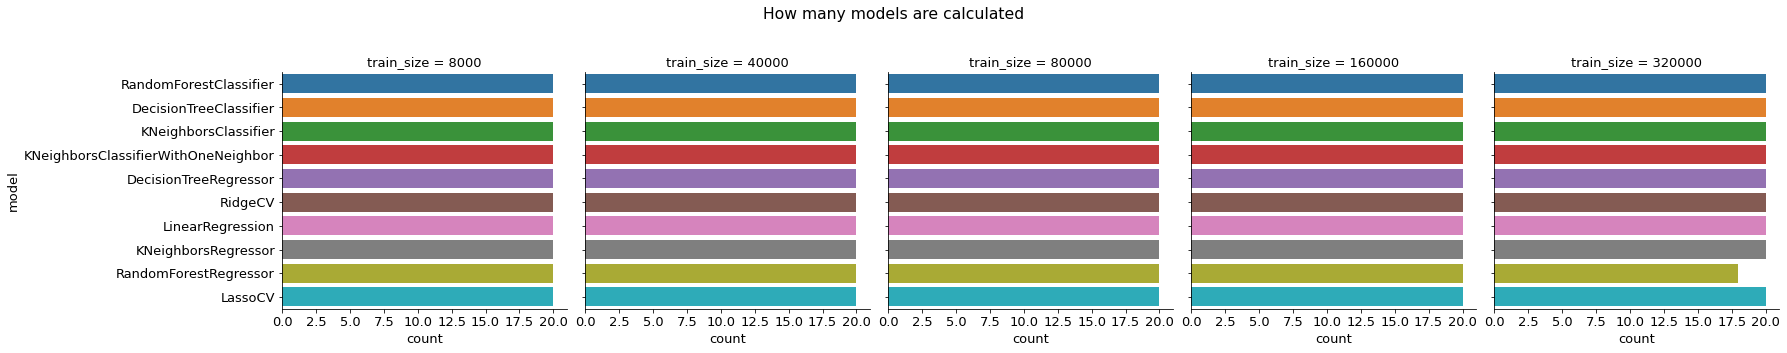

In [8]:
progress_bar(df_ampc_single.loc[df_ampc_single.top_threshold != 'Hit(top 50.0%)'])

In [11]:
df_ampc_single.shape

(1047, 11)

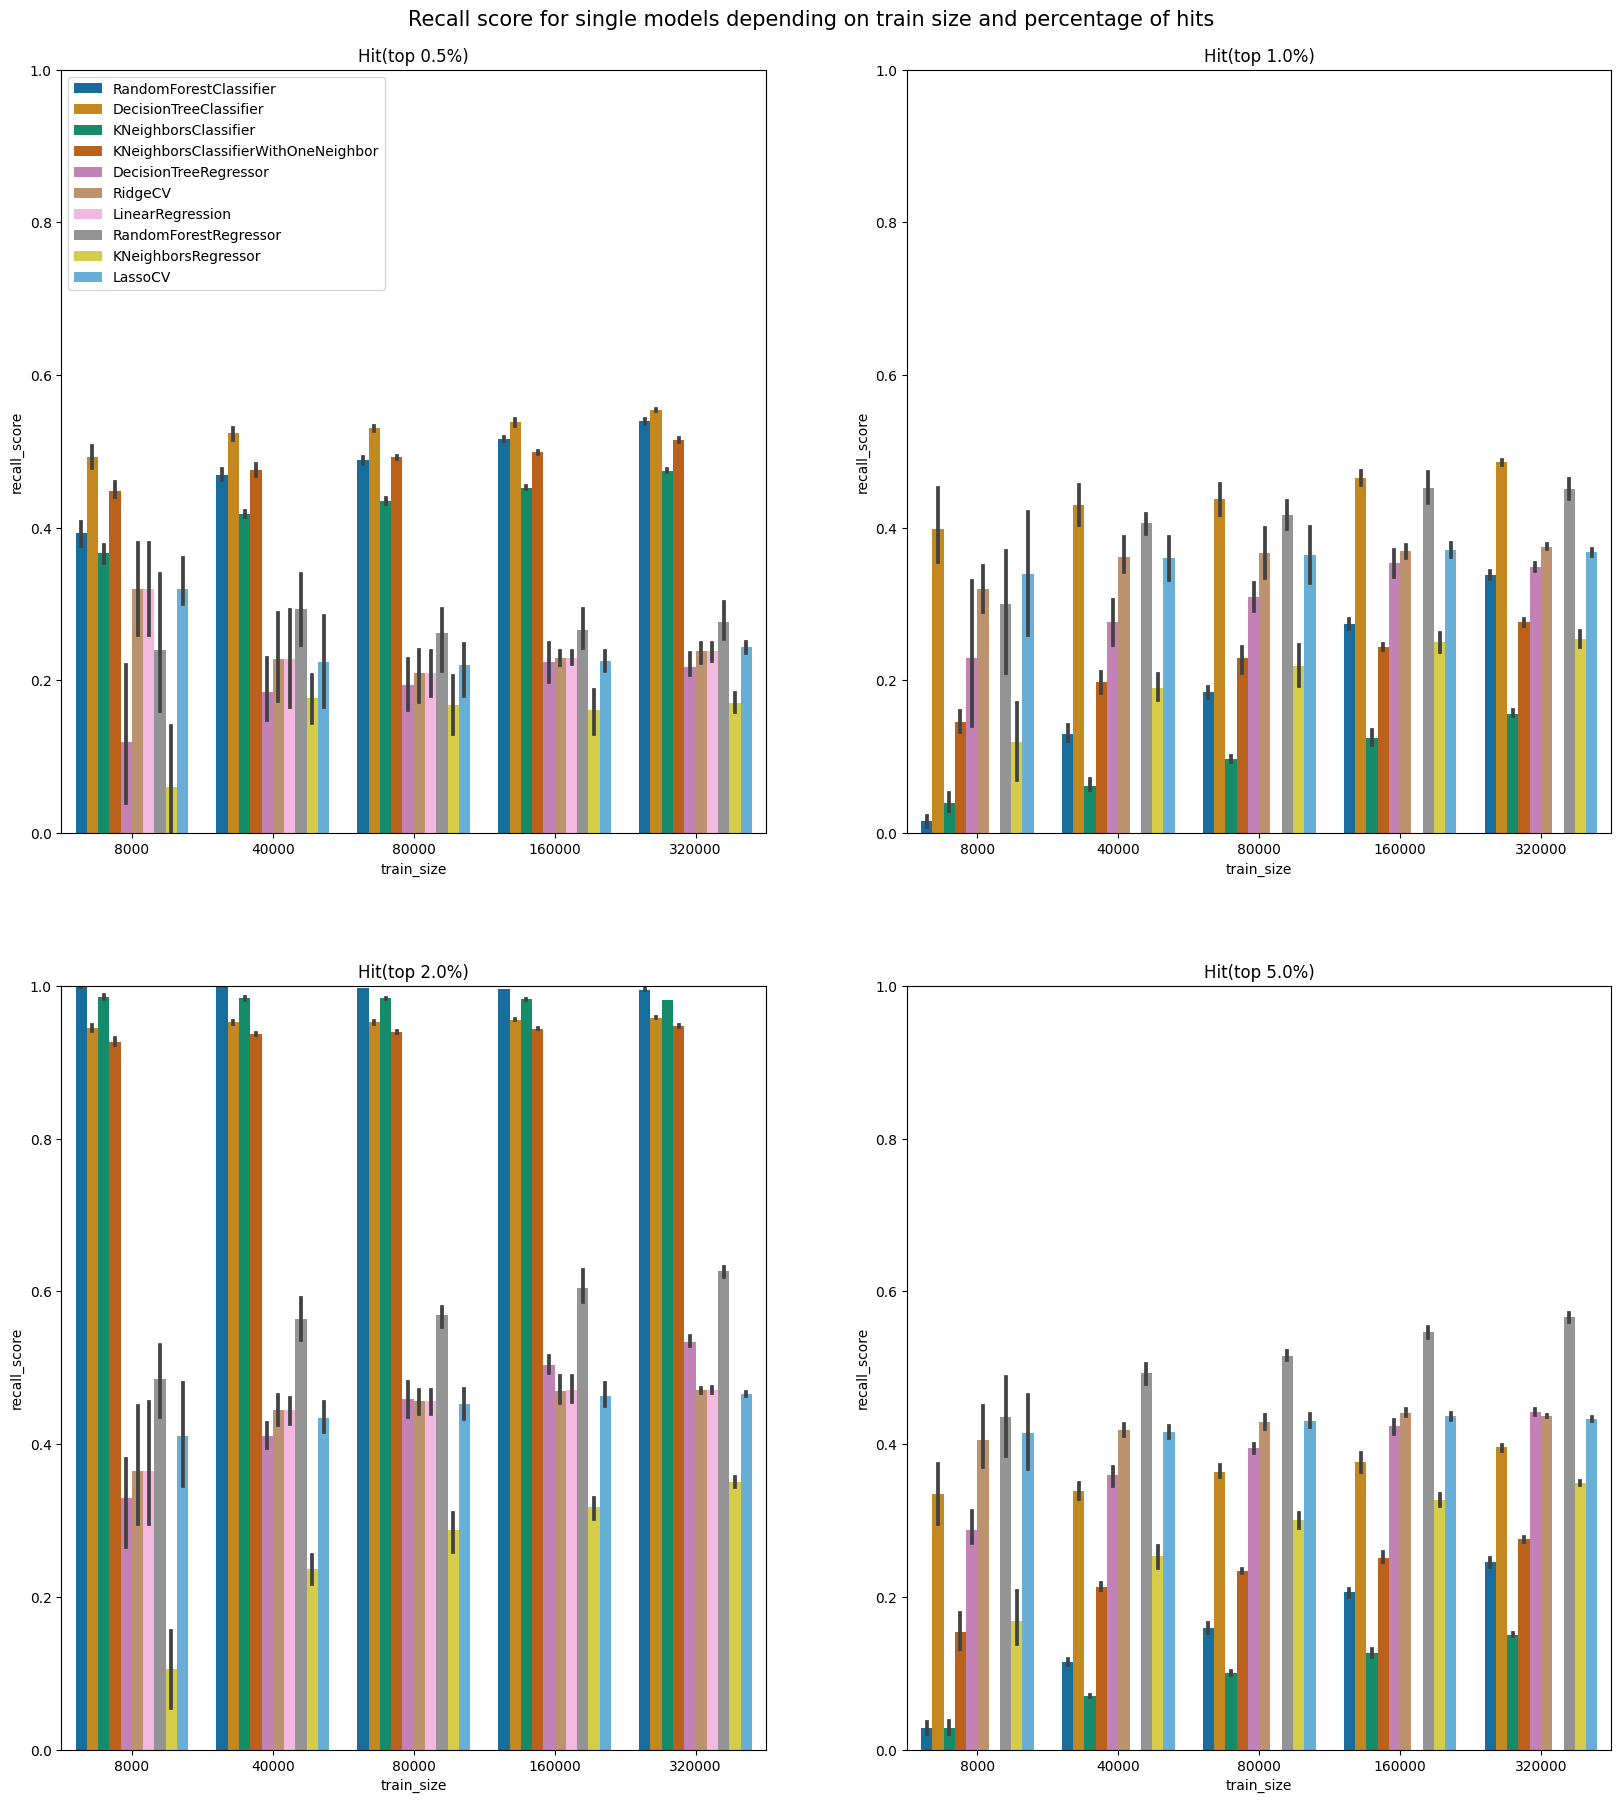

In [9]:
recall_plot_2(df_ampc_single)
#check StratifiedKFold!
#another metric

### Iterations

In [14]:
df_ampc_iterations = create_final_table_iterations('AmpC_screen_table_1M')
# df_ampc_iterations = load_final_table_iterations('AmpC_screen_table_1M')

loading from AmpC_screen_table_1M/tables_for_prediction/Morgan_size=2048_radius=2
writing to AmpC_screen_table_1M/result_iterations_Morgan_size=2048_radius=2.csv


In [16]:
# for _, row in df_ampc_iterations.iterrows():

#     model, threshold, train_size = row.model, row.threshold
#     df_iterations_ampc[()].loc[row[added_molecules]][]

In [17]:
df_ampc_iterations.sample(5)
#table with information about iteration at which molecule was added
#sparse matrix - scipy sparse matrix, pandas

,iteration,model,type,prediction_method,tot_num_of_iterations,add_to_train,docked_size,median_score,percentage_of_hits,added_molecules
2076,1,DecisionTreeClassifier,classifier,MeanRank,8,True,30000,-32.220,28.826667,"[ZINC000262072256, ZINC000263272957, ZINC00006..."
1179,14,LinearRegression,regressor,TopFromEveryModel,30,noadd,112000,-65.850,93.560000,"[ZINC000352644390, ZINC000016806897, ZINC00008..."
1739,22,DecisionTreeClassifier,classifier,LastModel,24,True,220000,-30.645,86.533333,"[ZINC000298169729, ZINC000058180535, ZINC00027..."
1905,24,DecisionTreeClassifier,classifier,TopFromEveryModel,24,True,240000,-30.730,88.280000,"[ZINC000519584316, ZINC000188936687, ZINC00028..."
2711,6,DecisionTreeClassifier,classifier,MeanRank,24,True,60000,-30.630,26.506667,"[ZINC000451443748, ZINC000097039472, ZINC00037..."


In [ ]:
#tables creation


# from itertools import product

# models = df_ampc_iterations.model.unique()
# methods = df_ampc_iterations.prediction_method.unique()
# num_of_iterations = df_ampc_iterations.tot_num_of_iterations.unique()
# add_to_trains = df_ampc_iterations.add_to_train.unique()

# index = raw_table.index
# columns = [info for info in product(models, methods, num_of_iterations, add_to_trains)]

# iterations_to_file = pd.DataFrame(index=index, columns=columns)


# for _, row in df_ampc_iterations.iterrows():

#     model, method, num_iter, add = row.model, row.prediction_method, row.tot_num_of_iterations, row.add_to_train
#     iterations_to_file[(model, method, num_iter, add)].loc[row.added_molecules] = row.iteration

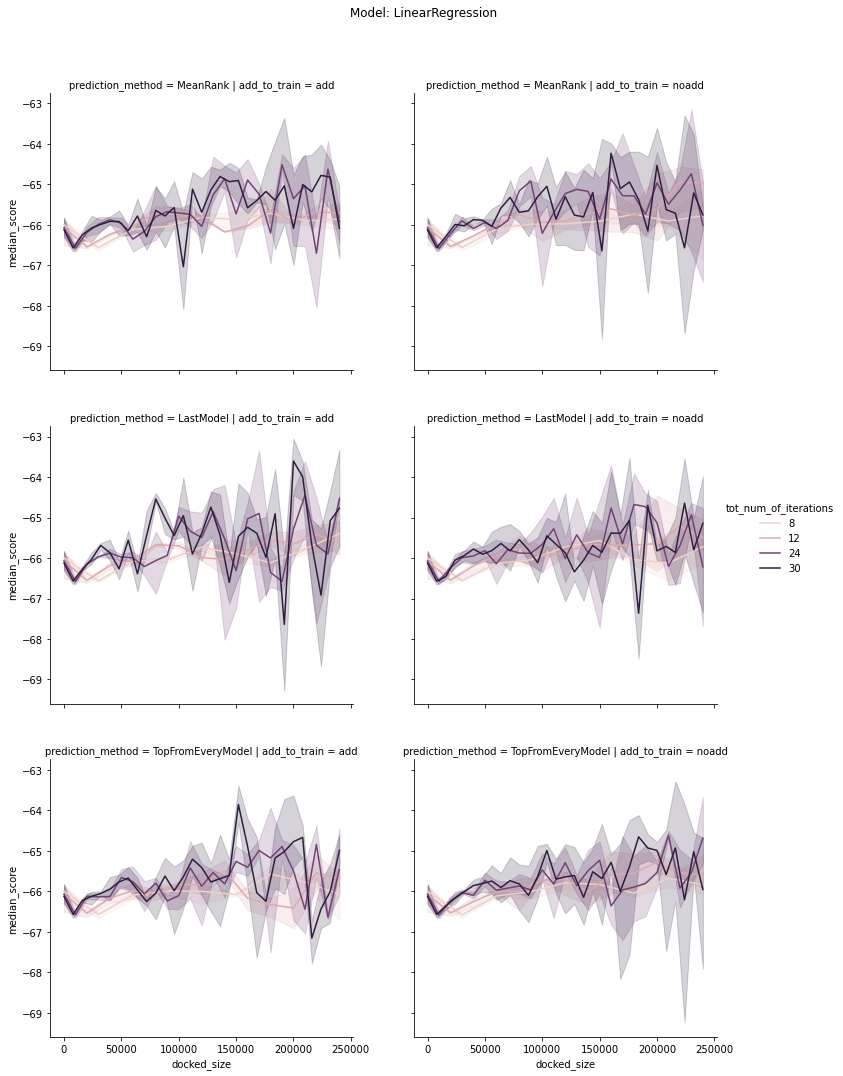

In [18]:
plot_median_score(df_ampc_iterations)
#top instead of random during iterations augmentation

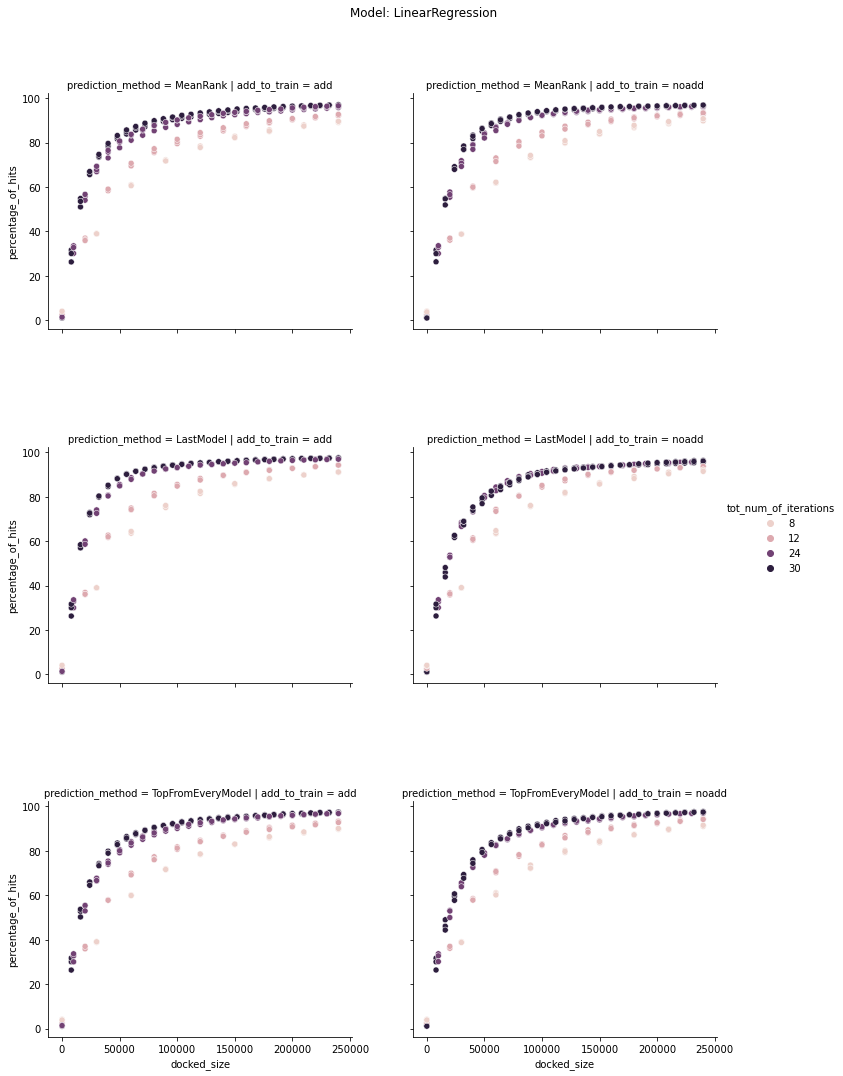

In [19]:
plot_number_of_hits(df_ampc_iterations)

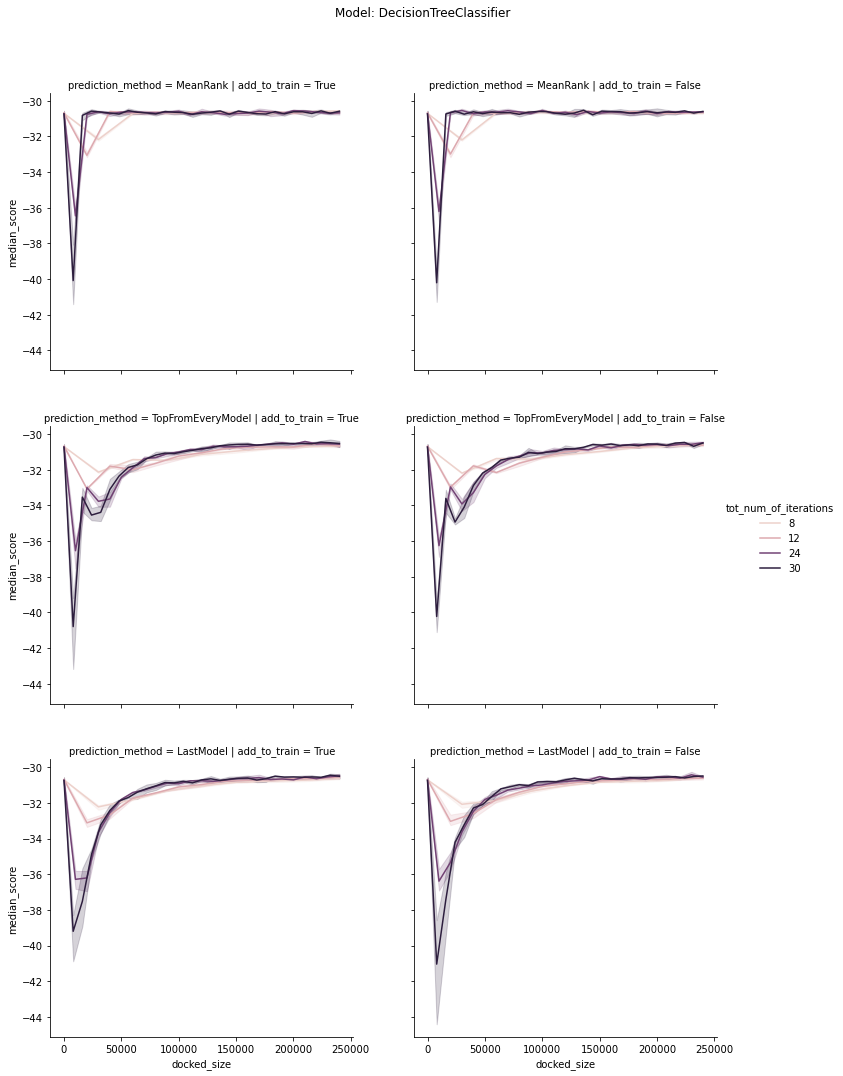

In [20]:
plot_median_score(df_ampc_iterations, 'DecisionTreeClassifier')

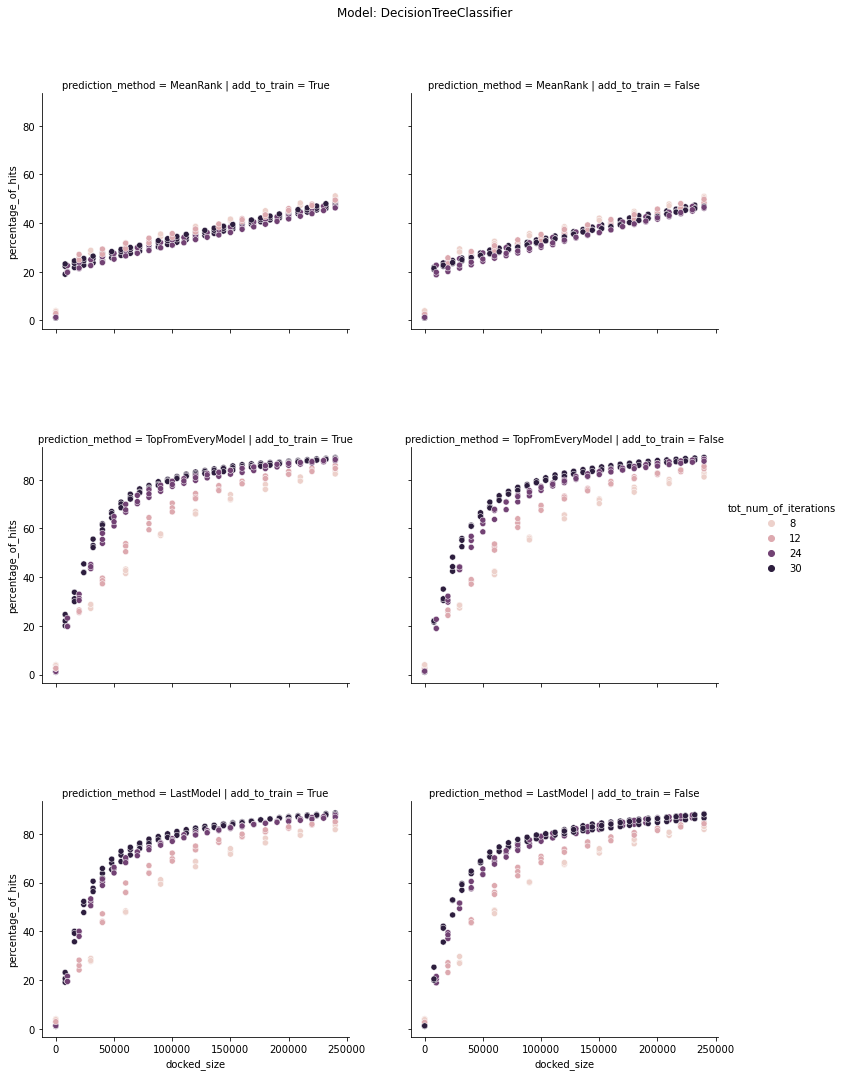

In [21]:
plot_number_of_hits(df_ampc_iterations, 'DecisionTreeClassifier')

# D4

In [19]:
%%time

path = '../data/D4_screen_table_1M'
df_d4_single = create_final_table_single(path) #if the table should be updated
# df_d4_single = load_final_table_single(path) #to download existing table

predictions_from_folder,  result_shape=(772, 7),  took=0:00:31.890663
regressor_data_labeling,  shape (772, 9)->(772, 9),  took=0:00:12.579058
predictions_from_folder,  result_shape=(374, 7),  took=0:00:21.376777
add_predicted_labels,  shape (374, 8)->(374, 8),  took=0:00:00.595888


/home/marinegor/github/wiselydock-manuscript/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinegor/github/wiselydock-manuscript/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinegor/github/wiselydock-manuscript/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/marinegor/

calc_metrics,  shape (1146, 17)->(1146, 17),  took=0:01:49.927775


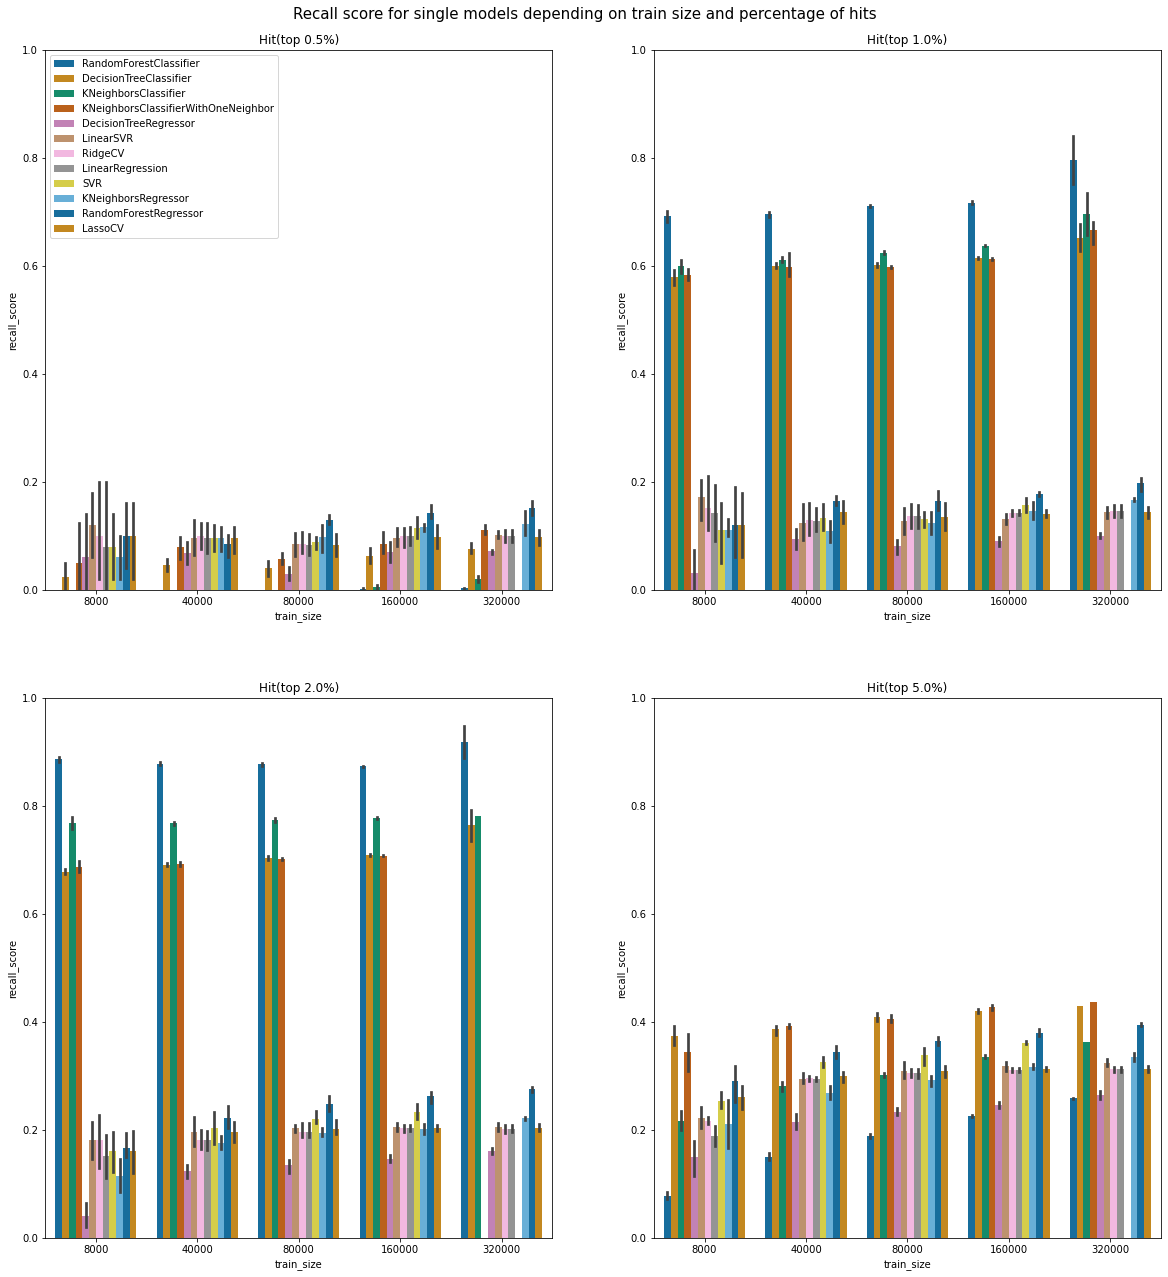

In [23]:
recall_plot_2(df_d4_single)

In [24]:
df_d4_iterations = create_final_table_iterations(path)
# df_d4_iterations = load_final_table_iterations(path)

loading from D4_screen_table_1M/tables_for_prediction/Morgan_size=2048_radius=2
writing to D4_screen_table_1M/result_iterations_Morgan_size=2048_radius=2.csv


In [25]:
df_d4_iterations.head()

,iteration,model,type,prediction_method,tot_num_of_iterations,add_to_train,docked_size,median_score,percentage_of_hits,added_molecules
0,0,LinearRegression,regressor,MeanRank,24,add,0,-29.280,1.317042,"[ZINC000174919855, ZINC000156825954, ZINC00061..."
1,1,LinearRegression,regressor,MeanRank,24,add,10000,-36.015,11.393209,"[ZINC000565833576, ZINC000631070084, ZINC00058..."
2,2,LinearRegression,regressor,MeanRank,24,add,20000,-36.365,22.294510,"[ZINC000389916455, ZINC000436308725, ZINC00042..."
3,3,LinearRegression,regressor,MeanRank,24,add,30000,-35.660,30.371311,"[ZINC000435055808, ZINC000352671221, ZINC00041..."
4,4,LinearRegression,regressor,MeanRank,24,add,40000,-34.960,36.877182,"[ZINC000292929578, ZINC000193265758, ZINC00043..."


In [26]:
df_d4_iterations.model.unique()

array(['LinearRegression', 'DecisionTreeClassifier'], dtype=object)

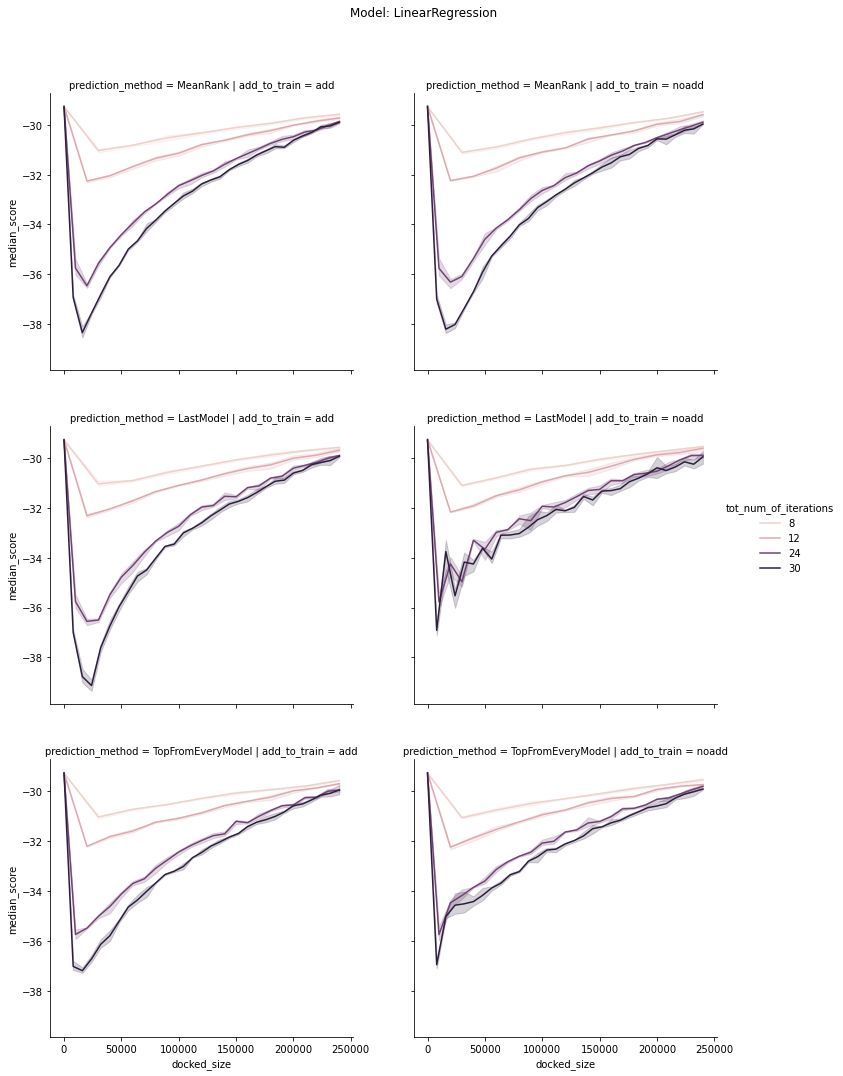

In [27]:
plot_median_score(df_d4_iterations)

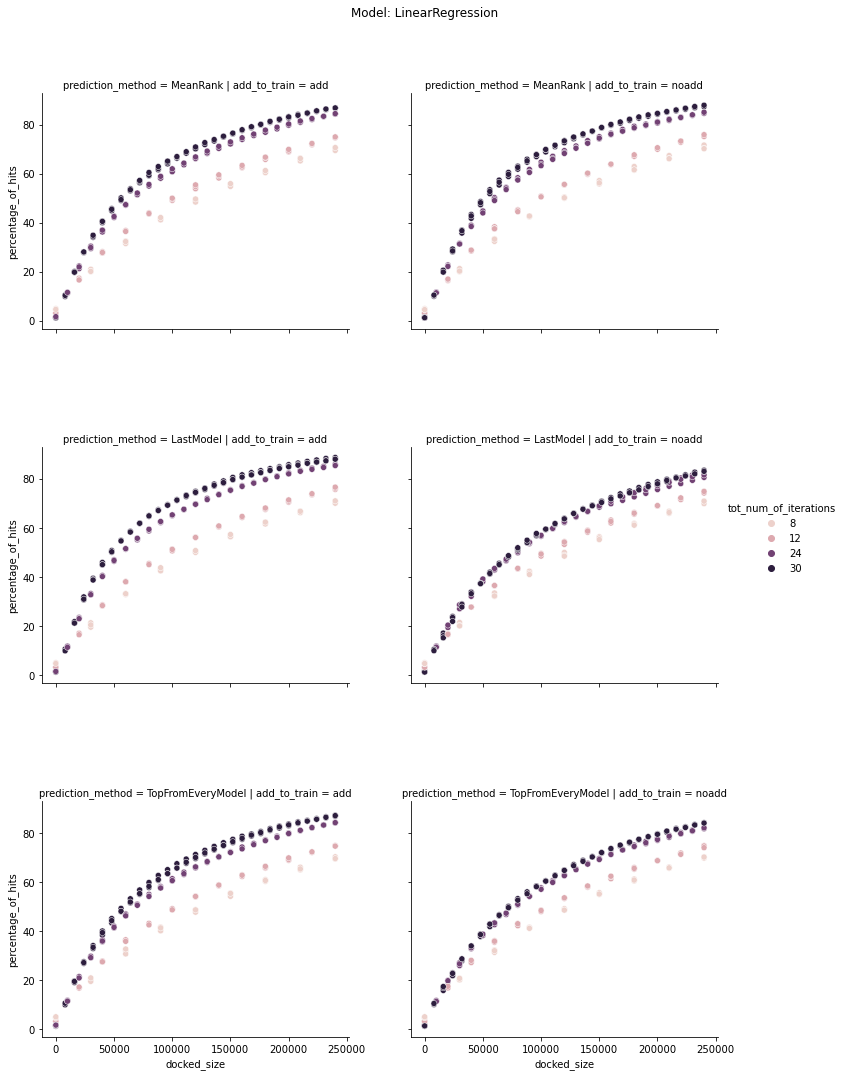

In [28]:
plot_number_of_hits(df_d4_iterations)

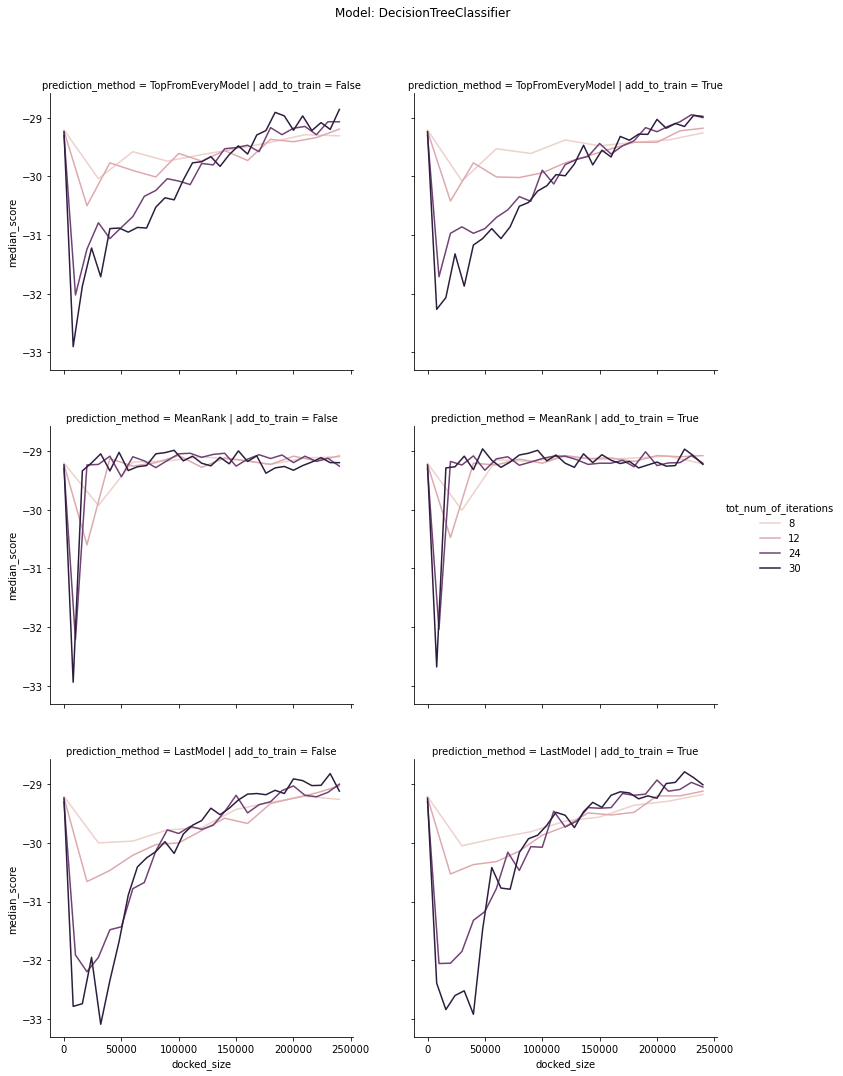

In [29]:
plot_median_score(df_d4_iterations, 'DecisionTreeClassifier')

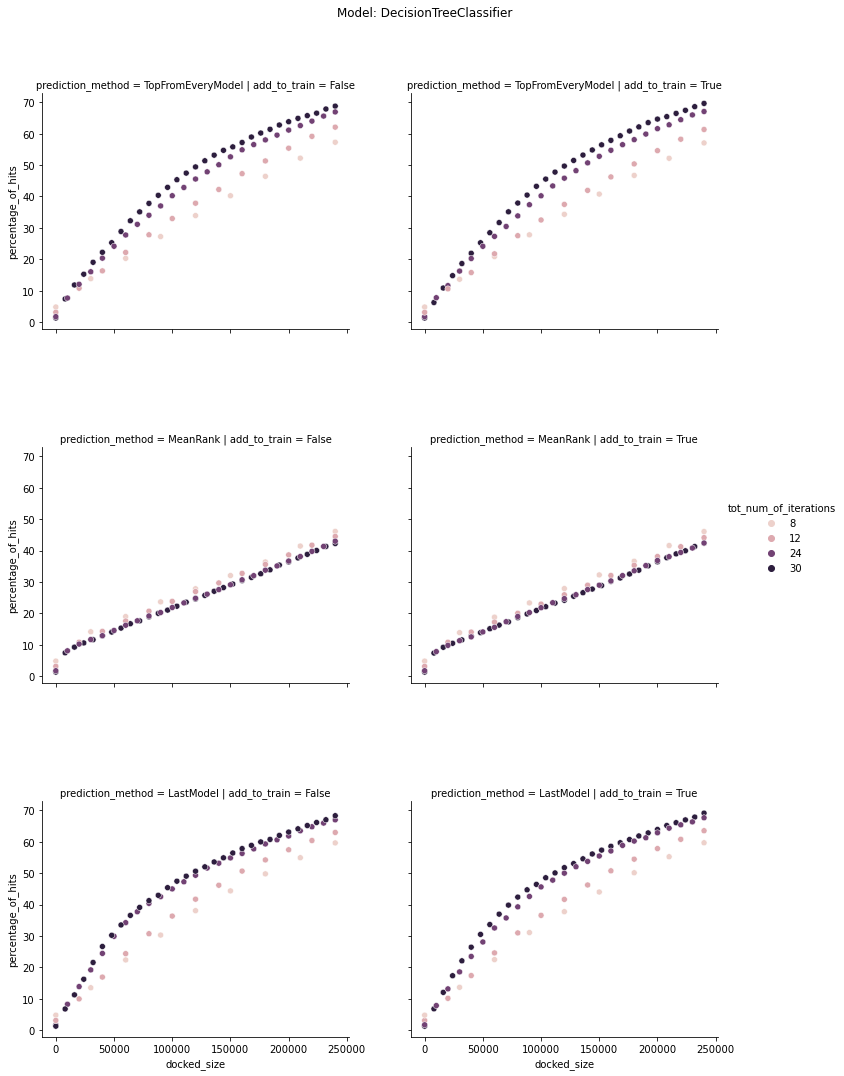

In [30]:
plot_number_of_hits(df_d4_iterations, 'DecisionTreeClassifier')